In [35]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import struct
import os
from tqdm import tqdm
from tqdm import trange
from tensorflow.python.client import device_lib


![lables_ubyte_structure](img/labels.png)

In [36]:
def load_mnist_train(path, kind='train'): 
    labels_path = os.path.join(path, '%s-labels.idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images.idx3-ubyte' % kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath,dtype=np.uint8)
    with open(images_path, 'rb') as imgpath: 
        magic, num, rows, cols = struct.unpack('>IIII',imgpath.read(16)) 
        images = np.fromfile(imgpath,dtype=np.uint8).reshape(len(labels), 784)
    
    return images, labels

![images_ubyte_structure](img/images.png)

In [37]:
def load_mnist_test(path, kind='t10k'): 
    labels_path = os.path.join(path,'%s-labels.idx1-ubyte'% kind) 
    images_path = os.path.join(path,'%s-images.idx3-ubyte'% kind) 
    with open(labels_path, 'rb') as lbpath: 
        magic, n = struct.unpack('>II',lbpath.read(8)) 
        labels = np.fromfile(lbpath,dtype=np.uint8) 
    with open(images_path, 'rb') as imgpath: 
        magic, num, rows, cols = struct.unpack('>IIII',imgpath.read(16)) 
        images = np.fromfile(imgpath,dtype=np.uint8).reshape(len(labels), 784)
    
    return images, labels

In [38]:
def check_available_gpus():
    local_devices = device_lib.list_local_devices()
    gpu_names = [x.name for x in device_lib.list_local_devices() if x.device_type == 'GPU']
    gpu_num = len(gpu_names)
    print('{0} GPUs are detected : {1}'.format(gpu_num, gpu_names))
    return gpu_num

In [39]:
check_available_gpus()
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

1 GPUs are detected : ['/device:GPU:0']


In [40]:
path = os.getcwd()
train_images, train_labels = load_mnist_train(path)
test_images, test_labels = load_mnist_test(path)
print(len(train_images))

60000


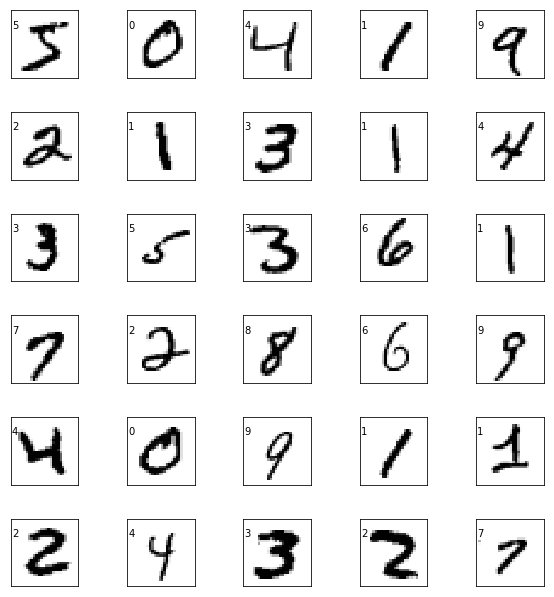

In [41]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.5, wspace=0.05)
for i in range(30):
    image = np.reshape(train_images[i],[28,28])
    ax=fig.add_subplot(6,5,i+1,xticks=[],yticks=[]) 
    ax.imshow(image,cmap=plt.cm.binary,interpolation='nearest') 
    ax.text(0,7,str(train_labels[i]))
plt.show()

In [42]:
train_epochs = 35
batch_size = 5000
noise_factor = 0.5

Input_height = 28
Input_width = 28

input_x = tf.placeholder(tf.float32, shape=[None, Input_height * Input_width], name='input')
input_matrix = tf.reshape(input_x, shape=[-1, Input_height, Input_width, 1])


#encode_processing
#input 28*28
#output 14*14*32
kernal_1 = tf.Variable(tf.truncated_normal(shape=[3,3,1,32], stddev=0.1, name='kernal_1'))
bias_1 = tf.Variable(tf.constant(0.0, shape=[32], name='bias_1'))
conv1 = tf.nn.conv2d(input=input_matrix, filter=kernal_1, strides=[1,1,1,1], padding='SAME')
conv1 = tf.nn.bias_add(conv1, bias_1, name='conv_1')
activ_1 = tf.nn.relu(conv1, name='activ_1')
pool1 = tf.nn.max_pool(value=activ_1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME', name='max_pool_1')
#pool1 = tf.layers.batch_normalization(pool1)


#input 14*14*32
#output 7*7*32
kernal_2 = tf.Variable(tf.truncated_normal(shape=[3, 3, 32, 32], stddev=0.1, name='kernal_2'))
bias_2 = tf.Variable(tf.constant(0.0, shape=[32], name='bias_2'))
conv2 = tf.nn.conv2d(input=pool1, filter=kernal_2, strides=[1, 1, 1, 1], padding='SAME')
conv2 = tf.nn.bias_add(conv2, bias_2, name='conv_2')
activ_2 = tf.nn.relu(conv2, name='activ_2')
pool2 = tf.nn.max_pool(value=activ_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='max_pool_2')
#pool2 = tf.layers.batch_normalization(pool2)

#input 7*7*32
#output 4*4*16
kernal_3 = tf.Variable(tf.truncated_normal(shape=[3, 3, 32, 16], stddev=0.1, name='kernal_3'))
bias_3 = tf.Variable(tf.constant(0.0, shape=[16]))
conv3 = tf.nn.conv2d(input=pool2, filter=kernal_3, strides=[1, 1, 1, 1], padding='SAME')
conv3 = tf.nn.bias_add(conv3, bias_3)
activ_3 = tf.nn.relu(conv3, name='activ_3')
pool3 = tf.nn.max_pool(value=activ_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='max_pool_3')
#pool3 = tf.layers.batch_normalization(pool3)

#input 4*4*16
#output 1*1*64
kernal_4 = tf.Variable(tf.truncated_normal(shape=[4, 4, 16, 64], stddev=0.1, name='kernal_4'))
bias_4 = tf.Variable(tf.constant(0.0, shape=[64]))
conv4 = tf.nn.conv2d(input=pool3, filter=kernal_4, strides=[1, 1, 1, 1], padding='SAME')
conv4 = tf.nn.bias_add(conv4, bias_4)
activ_4 = tf.nn.relu(conv4, name='activ_4')
pool4 = tf.nn.max_pool(value=activ_4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='max_pool_4')


#decode_processing
deconv_weight_0 = tf.Variable(tf.truncated_normal(shape=[4, 4, 16, 64], stddev=0.1), name='deconv_weight_0')
deconv0 = tf.nn.conv2d_transpose(value=pool4, filter=deconv_weight_0, output_shape=[batch_size, 4, 4, 16], strides=[1, 2, 2, 1], padding='SAME', name='deconv_1')


#input 4*4*16
#output 7*7*32
deconv_weight_1 = tf.Variable(tf.truncated_normal(shape=[3, 3, 32, 16], stddev=0.1), name='deconv_weight_1')
deconv1 = tf.nn.conv2d_transpose(value=pool3, filter=deconv_weight_1, output_shape=[batch_size, 7, 7, 32], strides=[1, 2, 2, 1], padding='SAME', name='deconv_1')

 
## 2 deconv layer
## input 7*7*32
## output 14*14*32
deconv_weight_2 = tf.Variable(tf.truncated_normal(shape=[3, 3,32, 32], stddev=0.1), name='deconv_weight_2')
deconv2 = tf.nn.conv2d_transpose(value=deconv1, filter=deconv_weight_2, output_shape=[batch_size, 14, 14, 32], strides=[1, 2, 2, 1], padding='SAME', name='deconv_2')
 

## 3 deconv layer
## input 14*14*32
## output 28*28*32
deconv_weight_3 = tf.Variable(tf.truncated_normal(shape=[3, 3, 32, 32], stddev=0.1, name='deconv_weight_3'))
deconv3 = tf.nn.conv2d_transpose(value=deconv2, filter=deconv_weight_3, output_shape=[batch_size, 28, 28, 32], strides=[1, 2, 2, 1], padding='SAME', name='deconv_3')


##CONV Layer
##input 28*28*32
##output 28*28*1
weight_final = tf.Variable(tf.truncated_normal(shape=[3, 3, 32, 1], stddev=0.1, name = 'weight_final'))
bias_final = tf.Variable(tf.constant(0.0, shape=[1], name='bias_final'))
conv_final = tf.nn.conv2d(input=deconv3, filter=weight_final, strides=[1, 1, 1, 1], padding='SAME')
conv_final = tf.nn.bias_add(conv_final, bias_final, name='conv_final')

output = tf.reshape(conv_final, shape=[-1,Input_height*Input_width])

loss = tf.reduce_mean(tf.pow(tf.subtract(output, input_x), 2.0),name='loss')
optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)
saver = tf.train.Saver()

In [43]:
if not os.path.exists('tmp/'):
    os.mkdir('tmp/')


In [53]:
#Training processing:
with tf.Session() as sess:
    if os.path.exists('tmp/checkpoint'):
        saver.restore(sess, 'tmp/model.ckpt')
    else:
        sess.run(tf.global_variables_initializer())
    total_batch  = int(len(train_images)/batch_size)
    min_lose = float('inf')
    for e in range(train_epochs):    
        for b in tqdm(range(total_batch)):
            batch = train_images[b*batch_size:(b+1)*batch_size]
            imgs = batch.reshape((-1,28,28,1))
            batch_cost, _=sess.run([loss, optimizer],feed_dict={input_x:batch})
            msg = "Global Step={:d}, Local batch={:d}, lose={:.4f}"
            if(batch_cost<min_lose):
                min_lose = batch_cost
                saver.save(sess, 'tmp/model.ckpt')
            print(msg.format(e,b,batch_cost))


INFO:tensorflow:Restoring parameters from tmp/model.ckpt


  8%|▊         | 1/12 [00:00<00:09,  1.20it/s]

Global Step=0, Local batch=0, lose=1716.9540


 17%|█▋        | 2/12 [00:01<00:06,  1.43it/s]

Global Step=0, Local batch=1, lose=1694.3051


 25%|██▌       | 3/12 [00:01<00:05,  1.72it/s]

Global Step=0, Local batch=2, lose=1696.4823


 33%|███▎      | 4/12 [00:01<00:04,  2.00it/s]

Global Step=0, Local batch=3, lose=1715.0886


 42%|████▏     | 5/12 [00:02<00:03,  2.26it/s]

Global Step=0, Local batch=4, lose=1719.8390


 50%|█████     | 6/12 [00:02<00:02,  2.45it/s]

Global Step=0, Local batch=5, lose=1702.0027


 58%|█████▊    | 7/12 [00:02<00:01,  2.66it/s]

Global Step=0, Local batch=6, lose=1719.4535


 67%|██████▋   | 8/12 [00:03<00:01,  2.83it/s]

Global Step=0, Local batch=7, lose=1732.9684


 75%|███████▌  | 9/12 [00:03<00:01,  2.95it/s]

Global Step=0, Local batch=8, lose=1724.2773


 83%|████████▎ | 10/12 [00:03<00:00,  3.04it/s]

Global Step=0, Local batch=9, lose=1744.8840


 92%|█████████▏| 11/12 [00:03<00:00,  3.10it/s]

Global Step=0, Local batch=10, lose=1705.4771


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=0, Local batch=11, lose=1698.1798


  8%|▊         | 1/12 [00:00<00:04,  2.45it/s]

Global Step=1, Local batch=0, lose=1681.4337


 17%|█▋        | 2/12 [00:00<00:04,  2.45it/s]

Global Step=1, Local batch=1, lose=1678.7153


 25%|██▌       | 3/12 [00:01<00:03,  2.61it/s]

Global Step=1, Local batch=2, lose=1697.6428


 33%|███▎      | 4/12 [00:01<00:02,  2.73it/s]

Global Step=1, Local batch=3, lose=1713.2097


 42%|████▏     | 5/12 [00:01<00:02,  2.89it/s]

Global Step=1, Local batch=4, lose=1712.5010


 50%|█████     | 6/12 [00:02<00:01,  3.01it/s]

Global Step=1, Local batch=5, lose=1693.3665


 58%|█████▊    | 7/12 [00:02<00:01,  3.09it/s]

Global Step=1, Local batch=6, lose=1712.4005


 67%|██████▋   | 8/12 [00:02<00:01,  3.12it/s]

Global Step=1, Local batch=7, lose=1741.2087


 75%|███████▌  | 9/12 [00:02<00:00,  3.15it/s]

Global Step=1, Local batch=8, lose=1744.9994


 83%|████████▎ | 10/12 [00:03<00:00,  3.15it/s]

Global Step=1, Local batch=9, lose=1738.5657


 92%|█████████▏| 11/12 [00:03<00:00,  2.92it/s]

Global Step=1, Local batch=10, lose=1678.1284


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=1, Local batch=11, lose=1697.8345


  8%|▊         | 1/12 [00:00<00:03,  2.98it/s]

Global Step=2, Local batch=0, lose=1690.6948


 17%|█▋        | 2/12 [00:00<00:03,  2.87it/s]

Global Step=2, Local batch=1, lose=1665.3763


 25%|██▌       | 3/12 [00:01<00:03,  2.99it/s]

Global Step=2, Local batch=2, lose=1677.8890


 33%|███▎      | 4/12 [00:01<00:02,  3.07it/s]

Global Step=2, Local batch=3, lose=1693.8929


 42%|████▏     | 5/12 [00:01<00:02,  3.07it/s]

Global Step=2, Local batch=4, lose=1693.6628


 50%|█████     | 6/12 [00:01<00:01,  3.10it/s]

Global Step=2, Local batch=5, lose=1686.0427


 58%|█████▊    | 7/12 [00:02<00:01,  3.08it/s]

Global Step=2, Local batch=6, lose=1687.6458


 67%|██████▋   | 8/12 [00:02<00:01,  3.13it/s]

Global Step=2, Local batch=7, lose=1683.5310


 75%|███████▌  | 9/12 [00:02<00:00,  3.14it/s]

Global Step=2, Local batch=8, lose=1706.4548


 83%|████████▎ | 10/12 [00:03<00:00,  3.20it/s]

Global Step=2, Local batch=9, lose=1734.2882


 92%|█████████▏| 11/12 [00:03<00:00,  3.26it/s]

Global Step=2, Local batch=10, lose=1668.6528


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=2, Local batch=11, lose=1687.1957


  8%|▊         | 1/12 [00:00<00:03,  3.14it/s]

Global Step=3, Local batch=0, lose=1675.9833


 17%|█▋        | 2/12 [00:00<00:03,  2.94it/s]

Global Step=3, Local batch=1, lose=1646.1245


 25%|██▌       | 3/12 [00:01<00:03,  3.00it/s]

Global Step=3, Local batch=2, lose=1677.8253


 33%|███▎      | 4/12 [00:01<00:02,  3.01it/s]

Global Step=3, Local batch=3, lose=1690.7114


 42%|████▏     | 5/12 [00:01<00:02,  3.07it/s]

Global Step=3, Local batch=4, lose=1671.9893


 50%|█████     | 6/12 [00:01<00:01,  3.11it/s]

Global Step=3, Local batch=5, lose=1674.4283


 58%|█████▊    | 7/12 [00:02<00:01,  3.14it/s]

Global Step=3, Local batch=6, lose=1681.1852


 67%|██████▋   | 8/12 [00:02<00:01,  3.14it/s]

Global Step=3, Local batch=7, lose=1682.7413


 75%|███████▌  | 9/12 [00:02<00:00,  3.19it/s]

Global Step=3, Local batch=8, lose=1711.9103


 83%|████████▎ | 10/12 [00:03<00:00,  3.25it/s]

Global Step=3, Local batch=9, lose=1737.1102


 92%|█████████▏| 11/12 [00:03<00:00,  3.27it/s]

Global Step=3, Local batch=10, lose=1660.1669


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=3, Local batch=11, lose=1681.3375


  8%|▊         | 1/12 [00:00<00:03,  3.34it/s]

Global Step=4, Local batch=0, lose=1661.0123


 17%|█▋        | 2/12 [00:00<00:03,  3.07it/s]

Global Step=4, Local batch=1, lose=1635.5684


 25%|██▌       | 3/12 [00:00<00:02,  3.15it/s]

Global Step=4, Local batch=2, lose=1670.5505


 33%|███▎      | 4/12 [00:01<00:02,  3.21it/s]

Global Step=4, Local batch=3, lose=1673.4452


 42%|████▏     | 5/12 [00:01<00:02,  3.26it/s]

Global Step=4, Local batch=4, lose=1670.1863


 50%|█████     | 6/12 [00:01<00:01,  3.28it/s]

Global Step=4, Local batch=5, lose=1680.5367


 58%|█████▊    | 7/12 [00:02<00:01,  3.30it/s]

Global Step=4, Local batch=6, lose=1668.2175


 67%|██████▋   | 8/12 [00:02<00:01,  3.31it/s]

Global Step=4, Local batch=7, lose=1676.9993


 75%|███████▌  | 9/12 [00:02<00:00,  3.32it/s]

Global Step=4, Local batch=8, lose=1702.8087


 83%|████████▎ | 10/12 [00:03<00:00,  3.33it/s]

Global Step=4, Local batch=9, lose=1712.3733


 92%|█████████▏| 11/12 [00:03<00:00,  3.32it/s]

Global Step=4, Local batch=10, lose=1672.4517


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=4, Local batch=11, lose=1690.4319


  8%|▊         | 1/12 [00:00<00:03,  3.37it/s]

Global Step=5, Local batch=0, lose=1642.5463


 17%|█▋        | 2/12 [00:00<00:02,  3.36it/s]

Global Step=5, Local batch=1, lose=1635.9009


 25%|██▌       | 3/12 [00:00<00:02,  3.36it/s]

Global Step=5, Local batch=2, lose=1650.4281


 33%|███▎      | 4/12 [00:01<00:02,  3.35it/s]

Global Step=5, Local batch=3, lose=1652.1881


 42%|████▏     | 5/12 [00:01<00:02,  3.34it/s]

Global Step=5, Local batch=4, lose=1676.4789


 50%|█████     | 6/12 [00:01<00:01,  3.33it/s]

Global Step=5, Local batch=5, lose=1646.2534


 58%|█████▊    | 7/12 [00:02<00:01,  3.33it/s]

Global Step=5, Local batch=6, lose=1640.1265


 67%|██████▋   | 8/12 [00:02<00:01,  3.32it/s]

Global Step=5, Local batch=7, lose=1673.7418


 75%|███████▌  | 9/12 [00:02<00:00,  3.31it/s]

Global Step=5, Local batch=8, lose=1665.3441


 83%|████████▎ | 10/12 [00:03<00:00,  3.30it/s]

Global Step=5, Local batch=9, lose=1688.5271


 92%|█████████▏| 11/12 [00:03<00:00,  3.31it/s]

Global Step=5, Local batch=10, lose=1666.2477


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=5, Local batch=11, lose=1659.7487


  8%|▊         | 1/12 [00:00<00:03,  3.35it/s]

Global Step=6, Local batch=0, lose=1639.1368


 17%|█▋        | 2/12 [00:00<00:03,  3.10it/s]

Global Step=6, Local batch=1, lose=1628.5344


 25%|██▌       | 3/12 [00:01<00:03,  2.96it/s]

Global Step=6, Local batch=2, lose=1623.8456


 33%|███▎      | 4/12 [00:01<00:02,  3.06it/s]

Global Step=6, Local batch=3, lose=1647.3156


 42%|████▏     | 5/12 [00:01<00:02,  3.13it/s]

Global Step=6, Local batch=4, lose=1661.0632


 50%|█████     | 6/12 [00:01<00:01,  3.20it/s]

Global Step=6, Local batch=5, lose=1629.1725


 58%|█████▊    | 7/12 [00:02<00:01,  3.18it/s]

Global Step=6, Local batch=6, lose=1646.3502


 67%|██████▋   | 8/12 [00:02<00:01,  3.20it/s]

Global Step=6, Local batch=7, lose=1669.5178


 75%|███████▌  | 9/12 [00:02<00:00,  3.19it/s]

Global Step=6, Local batch=8, lose=1658.5277


 83%|████████▎ | 10/12 [00:03<00:00,  3.23it/s]

Global Step=6, Local batch=9, lose=1686.0360


 92%|█████████▏| 11/12 [00:03<00:00,  3.28it/s]

Global Step=6, Local batch=10, lose=1656.0477


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=6, Local batch=11, lose=1649.3596


  8%|▊         | 1/12 [00:00<00:04,  2.54it/s]

Global Step=7, Local batch=0, lose=1623.4332


 17%|█▋        | 2/12 [00:00<00:03,  2.50it/s]

Global Step=7, Local batch=1, lose=1611.7255


 25%|██▌       | 3/12 [00:01<00:03,  2.65it/s]

Global Step=7, Local batch=2, lose=1614.0490


 33%|███▎      | 4/12 [00:01<00:02,  2.79it/s]

Global Step=7, Local batch=3, lose=1637.5510


 42%|████▏     | 5/12 [00:01<00:02,  2.88it/s]

Global Step=7, Local batch=4, lose=1650.2042


 50%|█████     | 6/12 [00:02<00:02,  2.95it/s]

Global Step=7, Local batch=5, lose=1614.4015


 58%|█████▊    | 7/12 [00:02<00:01,  2.99it/s]

Global Step=7, Local batch=6, lose=1621.8149


 67%|██████▋   | 8/12 [00:02<00:01,  3.03it/s]

Global Step=7, Local batch=7, lose=1643.9893


 75%|███████▌  | 9/12 [00:03<00:00,  3.01it/s]

Global Step=7, Local batch=8, lose=1641.9039


 83%|████████▎ | 10/12 [00:03<00:00,  3.02it/s]

Global Step=7, Local batch=9, lose=1668.7917


 92%|█████████▏| 11/12 [00:03<00:00,  3.01it/s]

Global Step=7, Local batch=10, lose=1645.0974


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=7, Local batch=11, lose=1653.5668


  8%|▊         | 1/12 [00:00<00:03,  2.96it/s]

Global Step=8, Local batch=0, lose=1632.0554


 17%|█▋        | 2/12 [00:00<00:03,  2.99it/s]

Global Step=8, Local batch=1, lose=1616.5967


 25%|██▌       | 3/12 [00:01<00:03,  2.83it/s]

Global Step=8, Local batch=2, lose=1611.0902


 33%|███▎      | 4/12 [00:01<00:02,  2.90it/s]

Global Step=8, Local batch=3, lose=1621.5170


 42%|████▏     | 5/12 [00:01<00:02,  3.02it/s]

Global Step=8, Local batch=4, lose=1635.2052


 50%|█████     | 6/12 [00:02<00:02,  2.90it/s]

Global Step=8, Local batch=5, lose=1610.6019


 58%|█████▊    | 7/12 [00:02<00:01,  3.00it/s]

Global Step=8, Local batch=6, lose=1611.0835


 67%|██████▋   | 8/12 [00:02<00:01,  3.05it/s]

Global Step=8, Local batch=7, lose=1627.7076


 75%|███████▌  | 9/12 [00:02<00:00,  3.09it/s]

Global Step=8, Local batch=8, lose=1635.4574


 83%|████████▎ | 10/12 [00:03<00:00,  3.13it/s]

Global Step=8, Local batch=9, lose=1660.9573


 92%|█████████▏| 11/12 [00:03<00:00,  3.13it/s]

Global Step=8, Local batch=10, lose=1625.6455


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=8, Local batch=11, lose=1629.6395


  8%|▊         | 1/12 [00:00<00:04,  2.55it/s]

Global Step=9, Local batch=0, lose=1601.6075


 17%|█▋        | 2/12 [00:00<00:03,  2.56it/s]

Global Step=9, Local batch=1, lose=1588.5221


 25%|██▌       | 3/12 [00:01<00:03,  2.70it/s]

Global Step=9, Local batch=2, lose=1605.9360


 33%|███▎      | 4/12 [00:01<00:02,  2.82it/s]

Global Step=9, Local batch=3, lose=1629.5923


 42%|████▏     | 5/12 [00:01<00:02,  2.92it/s]

Global Step=9, Local batch=4, lose=1657.8617


 50%|█████     | 6/12 [00:02<00:02,  2.96it/s]

Global Step=9, Local batch=5, lose=1687.3574


 58%|█████▊    | 7/12 [00:02<00:01,  2.99it/s]

Global Step=9, Local batch=6, lose=1764.2944


 67%|██████▋   | 8/12 [00:02<00:01,  3.00it/s]

Global Step=9, Local batch=7, lose=1738.5055


 75%|███████▌  | 9/12 [00:03<00:00,  3.04it/s]

Global Step=9, Local batch=8, lose=1655.6367


 83%|████████▎ | 10/12 [00:03<00:00,  3.07it/s]

Global Step=9, Local batch=9, lose=1711.2228


 92%|█████████▏| 11/12 [00:03<00:00,  3.14it/s]

Global Step=9, Local batch=10, lose=1651.5956


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=9, Local batch=11, lose=1628.7622


  8%|▊         | 1/12 [00:00<00:03,  3.31it/s]

Global Step=10, Local batch=0, lose=1650.4192


 17%|█▋        | 2/12 [00:00<00:03,  3.29it/s]

Global Step=10, Local batch=1, lose=1603.6840


 25%|██▌       | 3/12 [00:00<00:02,  3.24it/s]

Global Step=10, Local batch=2, lose=1621.5432


 33%|███▎      | 4/12 [00:01<00:02,  3.23it/s]

Global Step=10, Local batch=3, lose=1630.6890


 42%|████▏     | 5/12 [00:01<00:02,  3.21it/s]

Global Step=10, Local batch=4, lose=1631.4513


 50%|█████     | 6/12 [00:01<00:01,  3.19it/s]

Global Step=10, Local batch=5, lose=1617.3167


 58%|█████▊    | 7/12 [00:02<00:01,  3.16it/s]

Global Step=10, Local batch=6, lose=1600.6661


 67%|██████▋   | 8/12 [00:02<00:01,  3.21it/s]

Global Step=10, Local batch=7, lose=1630.9847


 75%|███████▌  | 9/12 [00:02<00:00,  3.22it/s]

Global Step=10, Local batch=8, lose=1621.5057


 83%|████████▎ | 10/12 [00:03<00:00,  3.13it/s]

Global Step=10, Local batch=9, lose=1633.7979


 92%|█████████▏| 11/12 [00:03<00:00,  3.17it/s]

Global Step=10, Local batch=10, lose=1619.0961


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=10, Local batch=11, lose=1604.8494


  8%|▊         | 1/12 [00:00<00:03,  3.18it/s]

Global Step=11, Local batch=0, lose=1591.9336


 17%|█▋        | 2/12 [00:00<00:03,  3.18it/s]

Global Step=11, Local batch=1, lose=1589.6465


 25%|██▌       | 3/12 [00:01<00:03,  2.80it/s]

Global Step=11, Local batch=2, lose=1581.0790


 33%|███▎      | 4/12 [00:01<00:02,  2.89it/s]

Global Step=11, Local batch=3, lose=1608.8130


 42%|████▏     | 5/12 [00:01<00:02,  3.00it/s]

Global Step=11, Local batch=4, lose=1611.0837


 50%|█████     | 6/12 [00:02<00:02,  2.75it/s]

Global Step=11, Local batch=5, lose=1572.4086


 58%|█████▊    | 7/12 [00:02<00:01,  2.84it/s]

Global Step=11, Local batch=6, lose=1600.6056


 67%|██████▋   | 8/12 [00:02<00:01,  2.98it/s]

Global Step=11, Local batch=7, lose=1610.0399


 75%|███████▌  | 9/12 [00:03<00:00,  3.02it/s]

Global Step=11, Local batch=8, lose=1604.2574


 83%|████████▎ | 10/12 [00:03<00:00,  3.08it/s]

Global Step=11, Local batch=9, lose=1639.8761


 92%|█████████▏| 11/12 [00:03<00:00,  3.09it/s]

Global Step=11, Local batch=10, lose=1600.4352


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=11, Local batch=11, lose=1596.4230


  8%|▊         | 1/12 [00:00<00:03,  3.17it/s]

Global Step=12, Local batch=0, lose=1580.6238


 17%|█▋        | 2/12 [00:00<00:03,  2.97it/s]

Global Step=12, Local batch=1, lose=1565.2173


 25%|██▌       | 3/12 [00:01<00:02,  3.04it/s]

Global Step=12, Local batch=2, lose=1566.9464


 33%|███▎      | 4/12 [00:01<00:02,  3.11it/s]

Global Step=12, Local batch=3, lose=1590.3597


 42%|████▏     | 5/12 [00:01<00:02,  3.17it/s]

Global Step=12, Local batch=4, lose=1598.5331


 50%|█████     | 6/12 [00:01<00:01,  3.20it/s]

Global Step=12, Local batch=5, lose=1573.9423


 58%|█████▊    | 7/12 [00:02<00:01,  3.22it/s]

Global Step=12, Local batch=6, lose=1578.2859


 67%|██████▋   | 8/12 [00:02<00:01,  3.20it/s]

Global Step=12, Local batch=7, lose=1588.8929


 75%|███████▌  | 9/12 [00:02<00:00,  3.17it/s]

Global Step=12, Local batch=8, lose=1590.7065


 83%|████████▎ | 10/12 [00:03<00:00,  3.16it/s]

Global Step=12, Local batch=9, lose=1619.7577


 92%|█████████▏| 11/12 [00:03<00:00,  3.14it/s]

Global Step=12, Local batch=10, lose=1600.8151


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=12, Local batch=11, lose=1616.2463


  8%|▊         | 1/12 [00:00<00:03,  3.33it/s]

Global Step=13, Local batch=0, lose=1591.1991


 17%|█▋        | 2/12 [00:00<00:03,  3.33it/s]

Global Step=13, Local batch=1, lose=1570.7194


 25%|██▌       | 3/12 [00:00<00:02,  3.32it/s]

Global Step=13, Local batch=2, lose=1569.7867


 33%|███▎      | 4/12 [00:01<00:02,  3.26it/s]

Global Step=13, Local batch=3, lose=1579.8268


 42%|████▏     | 5/12 [00:01<00:02,  3.25it/s]

Global Step=13, Local batch=4, lose=1582.5132


 50%|█████     | 6/12 [00:01<00:01,  3.22it/s]

Global Step=13, Local batch=5, lose=1569.8169


 58%|█████▊    | 7/12 [00:02<00:01,  3.20it/s]

Global Step=13, Local batch=6, lose=1571.6091


 67%|██████▋   | 8/12 [00:02<00:01,  3.18it/s]

Global Step=13, Local batch=7, lose=1575.5669


 75%|███████▌  | 9/12 [00:02<00:00,  3.22it/s]

Global Step=13, Local batch=8, lose=1591.8291


 83%|████████▎ | 10/12 [00:03<00:00,  3.25it/s]

Global Step=13, Local batch=9, lose=1622.5548


 92%|█████████▏| 11/12 [00:03<00:00,  3.26it/s]

Global Step=13, Local batch=10, lose=1586.9354


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=13, Local batch=11, lose=1595.3862


  8%|▊         | 1/12 [00:00<00:03,  3.32it/s]

Global Step=14, Local batch=0, lose=1573.7091


 17%|█▋        | 2/12 [00:00<00:03,  3.02it/s]

Global Step=14, Local batch=1, lose=1550.9871


 25%|██▌       | 3/12 [00:01<00:02,  3.04it/s]

Global Step=14, Local batch=2, lose=1561.0707


 33%|███▎      | 4/12 [00:01<00:02,  3.06it/s]

Global Step=14, Local batch=3, lose=1582.5940


 42%|████▏     | 5/12 [00:01<00:02,  3.07it/s]

Global Step=14, Local batch=4, lose=1576.6919


 50%|█████     | 6/12 [00:01<00:01,  3.08it/s]

Global Step=14, Local batch=5, lose=1560.1683


 58%|█████▊    | 7/12 [00:02<00:01,  3.16it/s]

Global Step=14, Local batch=6, lose=1569.6052


 67%|██████▋   | 8/12 [00:02<00:01,  3.20it/s]

Global Step=14, Local batch=7, lose=1583.0844


 75%|███████▌  | 9/12 [00:02<00:00,  3.22it/s]

Global Step=14, Local batch=8, lose=1602.9840


 83%|████████▎ | 10/12 [00:03<00:00,  3.22it/s]

Global Step=14, Local batch=9, lose=1650.9126


 92%|█████████▏| 11/12 [00:03<00:00,  3.18it/s]

Global Step=14, Local batch=10, lose=1607.8121


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=14, Local batch=11, lose=1619.5171


  8%|▊         | 1/12 [00:00<00:03,  3.15it/s]

Global Step=15, Local batch=0, lose=1590.0985


 17%|█▋        | 2/12 [00:00<00:03,  3.19it/s]

Global Step=15, Local batch=1, lose=1565.0248


 25%|██▌       | 3/12 [00:00<00:02,  3.21it/s]

Global Step=15, Local batch=2, lose=1558.8153


 33%|███▎      | 4/12 [00:01<00:02,  3.22it/s]

Global Step=15, Local batch=3, lose=1573.3296


 42%|████▏     | 5/12 [00:01<00:02,  3.23it/s]

Global Step=15, Local batch=4, lose=1573.3076


 50%|█████     | 6/12 [00:01<00:01,  3.22it/s]

Global Step=15, Local batch=5, lose=1560.5319


 58%|█████▊    | 7/12 [00:02<00:01,  3.16it/s]

Global Step=15, Local batch=6, lose=1581.7714


 67%|██████▋   | 8/12 [00:02<00:01,  3.14it/s]

Global Step=15, Local batch=7, lose=1594.9773


 75%|███████▌  | 9/12 [00:02<00:00,  3.12it/s]

Global Step=15, Local batch=8, lose=1599.2096


 83%|████████▎ | 10/12 [00:03<00:00,  3.13it/s]

Global Step=15, Local batch=9, lose=1616.8901


 92%|█████████▏| 11/12 [00:03<00:00,  3.16it/s]

Global Step=15, Local batch=10, lose=1568.3163


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=15, Local batch=11, lose=1570.2449


  8%|▊         | 1/12 [00:00<00:03,  3.33it/s]

Global Step=16, Local batch=0, lose=1567.1465


 17%|█▋        | 2/12 [00:00<00:03,  3.31it/s]

Global Step=16, Local batch=1, lose=1563.6256


 25%|██▌       | 3/12 [00:00<00:02,  3.31it/s]

Global Step=16, Local batch=2, lose=1558.4230


 33%|███▎      | 4/12 [00:01<00:02,  3.32it/s]

Global Step=16, Local batch=3, lose=1569.2231


 42%|████▏     | 5/12 [00:01<00:02,  3.32it/s]

Global Step=16, Local batch=4, lose=1566.4904


 50%|█████     | 6/12 [00:01<00:01,  3.30it/s]

Global Step=16, Local batch=5, lose=1555.3665


 58%|█████▊    | 7/12 [00:02<00:01,  3.27it/s]

Global Step=16, Local batch=6, lose=1565.6221


 67%|██████▋   | 8/12 [00:02<00:01,  3.28it/s]

Global Step=16, Local batch=7, lose=1561.8634


 75%|███████▌  | 9/12 [00:02<00:00,  3.27it/s]

Global Step=16, Local batch=8, lose=1560.6406


 83%|████████▎ | 10/12 [00:03<00:00,  3.28it/s]

Global Step=16, Local batch=9, lose=1594.7756


 92%|█████████▏| 11/12 [00:03<00:00,  3.29it/s]

Global Step=16, Local batch=10, lose=1563.8386


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=16, Local batch=11, lose=1567.4966


  8%|▊         | 1/12 [00:00<00:04,  2.62it/s]

Global Step=17, Local batch=0, lose=1549.8038


 17%|█▋        | 2/12 [00:00<00:03,  2.61it/s]

Global Step=17, Local batch=1, lose=1544.1964


 25%|██▌       | 3/12 [00:01<00:03,  2.77it/s]

Global Step=17, Local batch=2, lose=1556.6792


 33%|███▎      | 4/12 [00:01<00:02,  2.90it/s]

Global Step=17, Local batch=3, lose=1580.4324


 42%|████▏     | 5/12 [00:01<00:02,  3.01it/s]

Global Step=17, Local batch=4, lose=1573.4347


 50%|█████     | 6/12 [00:02<00:01,  3.06it/s]

Global Step=17, Local batch=5, lose=1549.6338


 58%|█████▊    | 7/12 [00:02<00:01,  3.12it/s]

Global Step=17, Local batch=6, lose=1557.5243


 67%|██████▋   | 8/12 [00:02<00:01,  3.17it/s]

Global Step=17, Local batch=7, lose=1580.6549


 75%|███████▌  | 9/12 [00:02<00:00,  3.21it/s]

Global Step=17, Local batch=8, lose=1593.3021


 83%|████████▎ | 10/12 [00:03<00:00,  3.23it/s]

Global Step=17, Local batch=9, lose=1616.8184


 92%|█████████▏| 11/12 [00:03<00:00,  3.26it/s]

Global Step=17, Local batch=10, lose=1562.5964


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=17, Local batch=11, lose=1566.8457


  8%|▊         | 1/12 [00:00<00:03,  2.95it/s]

Global Step=18, Local batch=0, lose=1552.9326


 17%|█▋        | 2/12 [00:00<00:03,  2.83it/s]

Global Step=18, Local batch=1, lose=1538.3722


 25%|██▌       | 3/12 [00:01<00:03,  2.64it/s]

Global Step=18, Local batch=2, lose=1534.6954


 33%|███▎      | 4/12 [00:01<00:02,  2.76it/s]

Global Step=18, Local batch=3, lose=1544.4189


 42%|████▏     | 5/12 [00:01<00:02,  2.90it/s]

Global Step=18, Local batch=4, lose=1545.6450


 50%|█████     | 6/12 [00:02<00:01,  3.01it/s]

Global Step=18, Local batch=5, lose=1537.4659


 58%|█████▊    | 7/12 [00:02<00:01,  3.08it/s]

Global Step=18, Local batch=6, lose=1559.2965


 67%|██████▋   | 8/12 [00:02<00:01,  3.08it/s]

Global Step=18, Local batch=7, lose=1569.5581


 75%|███████▌  | 9/12 [00:03<00:00,  3.09it/s]

Global Step=18, Local batch=8, lose=1574.2067


 83%|████████▎ | 10/12 [00:03<00:00,  3.02it/s]

Global Step=18, Local batch=9, lose=1586.2621


 92%|█████████▏| 11/12 [00:03<00:00,  3.01it/s]

Global Step=18, Local batch=10, lose=1542.1875


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=18, Local batch=11, lose=1551.5225


  8%|▊         | 1/12 [00:00<00:03,  3.25it/s]

Global Step=19, Local batch=0, lose=1549.1344


 17%|█▋        | 2/12 [00:00<00:03,  3.26it/s]

Global Step=19, Local batch=1, lose=1555.1432


 25%|██▌       | 3/12 [00:00<00:02,  3.27it/s]

Global Step=19, Local batch=2, lose=1555.5059


 33%|███▎      | 4/12 [00:01<00:02,  3.29it/s]

Global Step=19, Local batch=3, lose=1568.8529


 42%|████▏     | 5/12 [00:01<00:02,  3.30it/s]

Global Step=19, Local batch=4, lose=1544.7117


 50%|█████     | 6/12 [00:01<00:01,  3.04it/s]

Global Step=19, Local batch=5, lose=1525.2396


 58%|█████▊    | 7/12 [00:02<00:01,  3.08it/s]

Global Step=19, Local batch=6, lose=1541.8231


 67%|██████▋   | 8/12 [00:02<00:01,  3.12it/s]

Global Step=19, Local batch=7, lose=1560.8618


 75%|███████▌  | 9/12 [00:02<00:00,  3.16it/s]

Global Step=19, Local batch=8, lose=1570.9148


 83%|████████▎ | 10/12 [00:03<00:00,  3.15it/s]

Global Step=19, Local batch=9, lose=1589.2938


 92%|█████████▏| 11/12 [00:03<00:00,  3.15it/s]

Global Step=19, Local batch=10, lose=1548.8619


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=19, Local batch=11, lose=1555.6788


  8%|▊         | 1/12 [00:00<00:03,  2.95it/s]

Global Step=20, Local batch=0, lose=1541.9269


 17%|█▋        | 2/12 [00:00<00:03,  2.89it/s]

Global Step=20, Local batch=1, lose=1535.5359


 25%|██▌       | 3/12 [00:01<00:03,  2.91it/s]

Global Step=20, Local batch=2, lose=1534.7582


 33%|███▎      | 4/12 [00:01<00:02,  2.92it/s]

Global Step=20, Local batch=3, lose=1541.4952


 42%|████▏     | 5/12 [00:01<00:02,  2.98it/s]

Global Step=20, Local batch=4, lose=1533.5385


 50%|█████     | 6/12 [00:02<00:02,  2.74it/s]

Global Step=20, Local batch=5, lose=1524.9355


 58%|█████▊    | 7/12 [00:02<00:01,  2.81it/s]

Global Step=20, Local batch=6, lose=1545.1887


 67%|██████▋   | 8/12 [00:02<00:01,  2.90it/s]

Global Step=20, Local batch=7, lose=1553.7860


 75%|███████▌  | 9/12 [00:03<00:01,  2.99it/s]

Global Step=20, Local batch=8, lose=1556.4744


 83%|████████▎ | 10/12 [00:03<00:00,  3.06it/s]

Global Step=20, Local batch=9, lose=1575.0339


 92%|█████████▏| 11/12 [00:03<00:00,  3.11it/s]

Global Step=20, Local batch=10, lose=1540.9314


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=20, Local batch=11, lose=1563.8058


  8%|▊         | 1/12 [00:00<00:03,  3.32it/s]

Global Step=21, Local batch=0, lose=1543.3547


 17%|█▋        | 2/12 [00:00<00:03,  3.01it/s]

Global Step=21, Local batch=1, lose=1524.6709


 25%|██▌       | 3/12 [00:01<00:03,  2.82it/s]

Global Step=21, Local batch=2, lose=1524.3950


 33%|███▎      | 4/12 [00:01<00:02,  2.89it/s]

Global Step=21, Local batch=3, lose=1548.2214


 42%|████▏     | 5/12 [00:01<00:02,  2.94it/s]

Global Step=21, Local batch=4, lose=1563.6409


 50%|█████     | 6/12 [00:02<00:01,  3.01it/s]

Global Step=21, Local batch=5, lose=1560.0227


 58%|█████▊    | 7/12 [00:02<00:01,  3.08it/s]

Global Step=21, Local batch=6, lose=1566.0472


 67%|██████▋   | 8/12 [00:02<00:01,  3.14it/s]

Global Step=21, Local batch=7, lose=1554.6904


 75%|███████▌  | 9/12 [00:02<00:00,  3.16it/s]

Global Step=21, Local batch=8, lose=1559.4067


 83%|████████▎ | 10/12 [00:03<00:00,  3.16it/s]

Global Step=21, Local batch=9, lose=1619.2303


 92%|█████████▏| 11/12 [00:03<00:00,  3.13it/s]

Global Step=21, Local batch=10, lose=1560.2443


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=21, Local batch=11, lose=1539.5402


  8%|▊         | 1/12 [00:00<00:04,  2.37it/s]

Global Step=22, Local batch=0, lose=1514.0273


 17%|█▋        | 2/12 [00:00<00:03,  2.54it/s]

Global Step=22, Local batch=1, lose=1524.3392


 25%|██▌       | 3/12 [00:01<00:03,  2.70it/s]

Global Step=22, Local batch=2, lose=1546.3940


 33%|███▎      | 4/12 [00:01<00:02,  2.84it/s]

Global Step=22, Local batch=3, lose=1545.5826


 42%|████▏     | 5/12 [00:01<00:02,  2.92it/s]

Global Step=22, Local batch=4, lose=1549.3068


 50%|█████     | 6/12 [00:02<00:02,  2.93it/s]

Global Step=22, Local batch=5, lose=1552.4390


 58%|█████▊    | 7/12 [00:02<00:01,  2.96it/s]

Global Step=22, Local batch=6, lose=1574.8523


 67%|██████▋   | 8/12 [00:02<00:01,  3.00it/s]

Global Step=22, Local batch=7, lose=1579.6908


 75%|███████▌  | 9/12 [00:03<00:00,  3.03it/s]

Global Step=22, Local batch=8, lose=1570.3019


 83%|████████▎ | 10/12 [00:03<00:00,  3.03it/s]

Global Step=22, Local batch=9, lose=1584.4895


 92%|█████████▏| 11/12 [00:03<00:00,  2.85it/s]

Global Step=22, Local batch=10, lose=1537.0809


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=22, Local batch=11, lose=1544.4458


  8%|▊         | 1/12 [00:00<00:03,  2.98it/s]

Global Step=23, Local batch=0, lose=1520.9587


 17%|█▋        | 2/12 [00:00<00:03,  2.78it/s]

Global Step=23, Local batch=1, lose=1505.9177


 25%|██▌       | 3/12 [00:01<00:03,  2.85it/s]

Global Step=23, Local batch=2, lose=1520.4402


 33%|███▎      | 4/12 [00:01<00:02,  2.89it/s]

Global Step=23, Local batch=3, lose=1538.6744


 42%|████▏     | 5/12 [00:01<00:02,  2.91it/s]

Global Step=23, Local batch=4, lose=1538.0590


 50%|█████     | 6/12 [00:02<00:02,  2.90it/s]

Global Step=23, Local batch=5, lose=1514.5867


 58%|█████▊    | 7/12 [00:02<00:01,  2.89it/s]

Global Step=23, Local batch=6, lose=1518.9364


 67%|██████▋   | 8/12 [00:02<00:01,  2.91it/s]

Global Step=23, Local batch=7, lose=1534.7932


 75%|███████▌  | 9/12 [00:03<00:01,  2.95it/s]

Global Step=23, Local batch=8, lose=1550.1864


 83%|████████▎ | 10/12 [00:03<00:00,  3.00it/s]

Global Step=23, Local batch=9, lose=1587.8435


 92%|█████████▏| 11/12 [00:03<00:00,  3.02it/s]

Global Step=23, Local batch=10, lose=1522.9900


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=23, Local batch=11, lose=1519.2948


  8%|▊         | 1/12 [00:00<00:03,  2.96it/s]

Global Step=24, Local batch=0, lose=1517.1842


 17%|█▋        | 2/12 [00:00<00:03,  2.98it/s]

Global Step=24, Local batch=1, lose=1506.4209


 25%|██▌       | 3/12 [00:01<00:03,  2.72it/s]

Global Step=24, Local batch=2, lose=1505.6221


 33%|███▎      | 4/12 [00:01<00:02,  2.79it/s]

Global Step=24, Local batch=3, lose=1517.2432


 42%|████▏     | 5/12 [00:01<00:02,  2.82it/s]

Global Step=24, Local batch=4, lose=1514.8097


 50%|█████     | 6/12 [00:02<00:02,  2.72it/s]

Global Step=24, Local batch=5, lose=1497.6614


 58%|█████▊    | 7/12 [00:02<00:01,  2.81it/s]

Global Step=24, Local batch=6, lose=1503.3235


 67%|██████▋   | 8/12 [00:02<00:01,  2.88it/s]

Global Step=24, Local batch=7, lose=1520.4852


 75%|███████▌  | 9/12 [00:03<00:01,  2.92it/s]

Global Step=24, Local batch=8, lose=1537.3226


 83%|████████▎ | 10/12 [00:03<00:00,  2.93it/s]

Global Step=24, Local batch=9, lose=1580.2852


 92%|█████████▏| 11/12 [00:03<00:00,  2.93it/s]

Global Step=24, Local batch=10, lose=1549.6302


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=24, Local batch=11, lose=1564.8123


  8%|▊         | 1/12 [00:00<00:03,  2.91it/s]

Global Step=25, Local batch=0, lose=1534.6501


 17%|█▋        | 2/12 [00:00<00:03,  2.96it/s]

Global Step=25, Local batch=1, lose=1514.7870


 25%|██▌       | 3/12 [00:00<00:03,  3.00it/s]

Global Step=25, Local batch=2, lose=1524.1152


 33%|███▎      | 4/12 [00:01<00:02,  3.01it/s]

Global Step=25, Local batch=3, lose=1547.9349


 42%|████▏     | 5/12 [00:01<00:02,  3.03it/s]

Global Step=25, Local batch=4, lose=1541.6222


 50%|█████     | 6/12 [00:01<00:01,  3.03it/s]

Global Step=25, Local batch=5, lose=1502.3739


 58%|█████▊    | 7/12 [00:02<00:01,  2.99it/s]

Global Step=25, Local batch=6, lose=1501.1962


 67%|██████▋   | 8/12 [00:02<00:01,  2.96it/s]

Global Step=25, Local batch=7, lose=1530.5267


 75%|███████▌  | 9/12 [00:03<00:01,  2.93it/s]

Global Step=25, Local batch=8, lose=1549.2473


 83%|████████▎ | 10/12 [00:03<00:00,  2.94it/s]

Global Step=25, Local batch=9, lose=1560.0299


 92%|█████████▏| 11/12 [00:03<00:00,  2.93it/s]

Global Step=25, Local batch=10, lose=1498.9882


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=25, Local batch=11, lose=1517.3824


  8%|▊         | 1/12 [00:00<00:03,  3.10it/s]

Global Step=26, Local batch=0, lose=1519.0480


 17%|█▋        | 2/12 [00:00<00:03,  3.10it/s]

Global Step=26, Local batch=1, lose=1498.0214


 25%|██▌       | 3/12 [00:00<00:02,  3.08it/s]

Global Step=26, Local batch=2, lose=1498.1240


 33%|███▎      | 4/12 [00:01<00:02,  3.05it/s]

Global Step=26, Local batch=3, lose=1522.3281


 42%|████▏     | 5/12 [00:01<00:02,  3.00it/s]

Global Step=26, Local batch=4, lose=1513.3551


 50%|█████     | 6/12 [00:02<00:02,  2.76it/s]

Global Step=26, Local batch=5, lose=1490.2006


 58%|█████▊    | 7/12 [00:02<00:01,  2.82it/s]

Global Step=26, Local batch=6, lose=1496.7004


 67%|██████▋   | 8/12 [00:02<00:01,  2.90it/s]

Global Step=26, Local batch=7, lose=1502.3527


 75%|███████▌  | 9/12 [00:03<00:01,  2.96it/s]

Global Step=26, Local batch=8, lose=1503.8040


 83%|████████▎ | 10/12 [00:03<00:00,  3.01it/s]

Global Step=26, Local batch=9, lose=1530.9156


 92%|█████████▏| 11/12 [00:03<00:00,  3.03it/s]

Global Step=26, Local batch=10, lose=1499.5560


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=26, Local batch=11, lose=1508.3934


  8%|▊         | 1/12 [00:00<00:03,  3.02it/s]

Global Step=27, Local batch=0, lose=1493.0580


 17%|█▋        | 2/12 [00:00<00:03,  2.78it/s]

Global Step=27, Local batch=1, lose=1485.1410


 25%|██▌       | 3/12 [00:01<00:03,  2.83it/s]

Global Step=27, Local batch=2, lose=1500.0249


 33%|███▎      | 4/12 [00:01<00:02,  2.90it/s]

Global Step=27, Local batch=3, lose=1544.6689


 42%|████▏     | 5/12 [00:01<00:02,  2.96it/s]

Global Step=27, Local batch=4, lose=1593.8345


 50%|█████     | 6/12 [00:02<00:02,  2.95it/s]

Global Step=27, Local batch=5, lose=1668.8236


 58%|█████▊    | 7/12 [00:02<00:01,  2.96it/s]

Global Step=27, Local batch=6, lose=1632.2047


 67%|██████▋   | 8/12 [00:02<00:01,  2.96it/s]

Global Step=27, Local batch=7, lose=1544.3252


 75%|███████▌  | 9/12 [00:03<00:01,  2.95it/s]

Global Step=27, Local batch=8, lose=1568.1440


 83%|████████▎ | 10/12 [00:03<00:00,  2.93it/s]

Global Step=27, Local batch=9, lose=1586.1041


 92%|█████████▏| 11/12 [00:03<00:00,  2.91it/s]

Global Step=27, Local batch=10, lose=1517.8381


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=27, Local batch=11, lose=1555.3422


  8%|▊         | 1/12 [00:00<00:03,  3.05it/s]

Global Step=28, Local batch=0, lose=1498.2183


 17%|█▋        | 2/12 [00:00<00:03,  3.00it/s]

Global Step=28, Local batch=1, lose=1521.6188


 25%|██▌       | 3/12 [00:01<00:02,  3.02it/s]

Global Step=28, Local batch=2, lose=1506.6394


 33%|███▎      | 4/12 [00:01<00:02,  3.00it/s]

Global Step=28, Local batch=3, lose=1522.5310


 42%|████▏     | 5/12 [00:01<00:02,  2.97it/s]

Global Step=28, Local batch=4, lose=1539.8545


 50%|█████     | 6/12 [00:02<00:02,  2.82it/s]

Global Step=28, Local batch=5, lose=1497.3285


 58%|█████▊    | 7/12 [00:02<00:01,  2.70it/s]

Global Step=28, Local batch=6, lose=1513.9224


 67%|██████▋   | 8/12 [00:02<00:01,  2.66it/s]

Global Step=28, Local batch=7, lose=1515.4935


 75%|███████▌  | 9/12 [00:03<00:01,  2.67it/s]

Global Step=28, Local batch=8, lose=1527.9896


 83%|████████▎ | 10/12 [00:03<00:00,  2.68it/s]

Global Step=28, Local batch=9, lose=1549.7224


 92%|█████████▏| 11/12 [00:03<00:00,  2.74it/s]

Global Step=28, Local batch=10, lose=1515.6528


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=28, Local batch=11, lose=1542.5874


  8%|▊         | 1/12 [00:00<00:03,  2.93it/s]

Global Step=29, Local batch=0, lose=1508.6559


 17%|█▋        | 2/12 [00:00<00:03,  2.91it/s]

Global Step=29, Local batch=1, lose=1487.3951


 25%|██▌       | 3/12 [00:01<00:03,  2.87it/s]

Global Step=29, Local batch=2, lose=1489.3658


 33%|███▎      | 4/12 [00:01<00:02,  2.83it/s]

Global Step=29, Local batch=3, lose=1507.5427


 42%|████▏     | 5/12 [00:01<00:02,  2.86it/s]

Global Step=29, Local batch=4, lose=1499.1514


 50%|█████     | 6/12 [00:02<00:02,  2.88it/s]

Global Step=29, Local batch=5, lose=1491.0414


 58%|█████▊    | 7/12 [00:02<00:01,  2.89it/s]

Global Step=29, Local batch=6, lose=1508.7162


 67%|██████▋   | 8/12 [00:02<00:01,  2.90it/s]

Global Step=29, Local batch=7, lose=1501.5643


 75%|███████▌  | 9/12 [00:03<00:01,  2.89it/s]

Global Step=29, Local batch=8, lose=1513.8523


 83%|████████▎ | 10/12 [00:03<00:00,  2.89it/s]

Global Step=29, Local batch=9, lose=1537.3949


 92%|█████████▏| 11/12 [00:03<00:00,  2.89it/s]

Global Step=29, Local batch=10, lose=1491.9683


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=29, Local batch=11, lose=1502.7371


  8%|▊         | 1/12 [00:00<00:03,  2.78it/s]

Global Step=30, Local batch=0, lose=1489.5205


 17%|█▋        | 2/12 [00:00<00:03,  2.56it/s]

Global Step=30, Local batch=1, lose=1476.8717


 25%|██▌       | 3/12 [00:01<00:03,  2.58it/s]

Global Step=30, Local batch=2, lose=1494.5800


 33%|███▎      | 4/12 [00:01<00:03,  2.61it/s]

Global Step=30, Local batch=3, lose=1515.8798


 42%|████▏     | 5/12 [00:01<00:02,  2.64it/s]

Global Step=30, Local batch=4, lose=1499.2848


 50%|█████     | 6/12 [00:02<00:02,  2.71it/s]

Global Step=30, Local batch=5, lose=1483.2572


 58%|█████▊    | 7/12 [00:02<00:01,  2.73it/s]

Global Step=30, Local batch=6, lose=1483.3317


 67%|██████▋   | 8/12 [00:02<00:01,  2.77it/s]

Global Step=30, Local batch=7, lose=1499.0309


 75%|███████▌  | 9/12 [00:03<00:01,  2.76it/s]

Global Step=30, Local batch=8, lose=1516.5786


 83%|████████▎ | 10/12 [00:03<00:00,  2.76it/s]

Global Step=30, Local batch=9, lose=1537.4376


 92%|█████████▏| 11/12 [00:04<00:00,  2.78it/s]

Global Step=30, Local batch=10, lose=1503.2476


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=30, Local batch=11, lose=1511.4136


  8%|▊         | 1/12 [00:00<00:03,  2.77it/s]

Global Step=31, Local batch=0, lose=1487.6805


 17%|█▋        | 2/12 [00:00<00:03,  2.60it/s]

Global Step=31, Local batch=1, lose=1471.1798


 25%|██▌       | 3/12 [00:01<00:03,  2.64it/s]

Global Step=31, Local batch=2, lose=1478.0431


 33%|███▎      | 4/12 [00:01<00:03,  2.66it/s]

Global Step=31, Local batch=3, lose=1501.0897


 42%|████▏     | 5/12 [00:01<00:02,  2.72it/s]

Global Step=31, Local batch=4, lose=1496.2390


 50%|█████     | 6/12 [00:02<00:02,  2.76it/s]

Global Step=31, Local batch=5, lose=1482.5890


 58%|█████▊    | 7/12 [00:02<00:01,  2.79it/s]

Global Step=31, Local batch=6, lose=1478.1671


 67%|██████▋   | 8/12 [00:02<00:01,  2.79it/s]

Global Step=31, Local batch=7, lose=1485.8396


 75%|███████▌  | 9/12 [00:03<00:01,  2.77it/s]

Global Step=31, Local batch=8, lose=1491.4321


 83%|████████▎ | 10/12 [00:03<00:00,  2.73it/s]

Global Step=31, Local batch=9, lose=1521.7141


 92%|█████████▏| 11/12 [00:04<00:00,  2.72it/s]

Global Step=31, Local batch=10, lose=1489.3450


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=31, Local batch=11, lose=1498.6273


  8%|▊         | 1/12 [00:00<00:04,  2.72it/s]

Global Step=32, Local batch=0, lose=1478.5475


 17%|█▋        | 2/12 [00:00<00:03,  2.73it/s]

Global Step=32, Local batch=1, lose=1471.5581


 25%|██▌       | 3/12 [00:01<00:03,  2.74it/s]

Global Step=32, Local batch=2, lose=1483.6405


 33%|███▎      | 4/12 [00:01<00:02,  2.71it/s]

Global Step=32, Local batch=3, lose=1511.9943


 42%|████▏     | 5/12 [00:01<00:02,  2.70it/s]

Global Step=32, Local batch=4, lose=1496.2461


 50%|█████     | 6/12 [00:02<00:02,  2.67it/s]

Global Step=32, Local batch=5, lose=1477.5112


 58%|█████▊    | 7/12 [00:02<00:01,  2.53it/s]

Global Step=32, Local batch=6, lose=1470.8784


 67%|██████▋   | 8/12 [00:03<00:01,  2.59it/s]

Global Step=32, Local batch=7, lose=1478.2292


 75%|███████▌  | 9/12 [00:03<00:01,  2.67it/s]

Global Step=32, Local batch=8, lose=1485.9559


 83%|████████▎ | 10/12 [00:03<00:00,  2.72it/s]

Global Step=32, Local batch=9, lose=1513.7792


 92%|█████████▏| 11/12 [00:04<00:00,  2.77it/s]

Global Step=32, Local batch=10, lose=1475.5011


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=32, Local batch=11, lose=1481.1077


  8%|▊         | 1/12 [00:00<00:04,  2.35it/s]

Global Step=33, Local batch=0, lose=1467.0510


 17%|█▋        | 2/12 [00:00<00:04,  2.35it/s]

Global Step=33, Local batch=1, lose=1454.9049


 25%|██▌       | 3/12 [00:01<00:03,  2.48it/s]

Global Step=33, Local batch=2, lose=1462.6276


 33%|███▎      | 4/12 [00:01<00:03,  2.61it/s]

Global Step=33, Local batch=3, lose=1486.2776


 42%|████▏     | 5/12 [00:01<00:02,  2.69it/s]

Global Step=33, Local batch=4, lose=1480.4741


 50%|█████     | 6/12 [00:02<00:02,  2.75it/s]

Global Step=33, Local batch=5, lose=1468.8533


 58%|█████▊    | 7/12 [00:02<00:01,  2.79it/s]

Global Step=33, Local batch=6, lose=1476.1373


 67%|██████▋   | 8/12 [00:02<00:01,  2.86it/s]

Global Step=33, Local batch=7, lose=1498.8326


 75%|███████▌  | 9/12 [00:03<00:01,  2.90it/s]

Global Step=33, Local batch=8, lose=1514.9324


 83%|████████▎ | 10/12 [00:03<00:00,  2.94it/s]

Global Step=33, Local batch=9, lose=1561.6334


 92%|█████████▏| 11/12 [00:03<00:00,  2.96it/s]

Global Step=33, Local batch=10, lose=1503.7988


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=33, Local batch=11, lose=1491.2280


  8%|▊         | 1/12 [00:00<00:03,  3.01it/s]

Global Step=34, Local batch=0, lose=1462.4059


 17%|█▋        | 2/12 [00:00<00:03,  2.97it/s]

Global Step=34, Local batch=1, lose=1457.0870


 25%|██▌       | 3/12 [00:01<00:03,  2.93it/s]

Global Step=34, Local batch=2, lose=1476.2281


 33%|███▎      | 4/12 [00:01<00:02,  2.92it/s]

Global Step=34, Local batch=3, lose=1511.8331


 42%|████▏     | 5/12 [00:01<00:02,  2.95it/s]

Global Step=34, Local batch=4, lose=1520.1864


 50%|█████     | 6/12 [00:02<00:02,  2.95it/s]

Global Step=34, Local batch=5, lose=1504.5363


 58%|█████▊    | 7/12 [00:02<00:01,  2.93it/s]

Global Step=34, Local batch=6, lose=1514.7662


 67%|██████▋   | 8/12 [00:02<00:01,  2.90it/s]

Global Step=34, Local batch=7, lose=1501.3542


 75%|███████▌  | 9/12 [00:03<00:01,  2.88it/s]

Global Step=34, Local batch=8, lose=1487.5587


 83%|████████▎ | 10/12 [00:03<00:00,  2.85it/s]

Global Step=34, Local batch=9, lose=1514.2704


 92%|█████████▏| 11/12 [00:03<00:00,  2.82it/s]

Global Step=34, Local batch=10, lose=1484.2542


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]

Global Step=34, Local batch=11, lose=1487.7820


INFO:tensorflow:Restoring parameters from tmp/model.ckpt


100%|██████████| 2/2 [00:00<00:00,  6.21it/s]

Test batch=0, lose=1477.9745
Test batch=1, lose=1440.6616


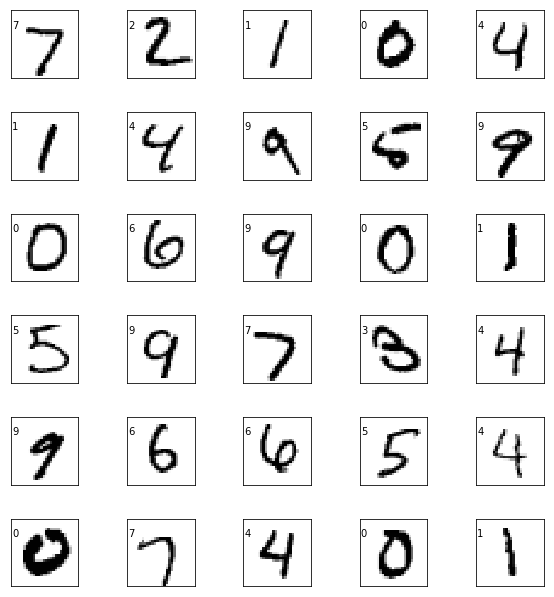

---------------------------------------------------


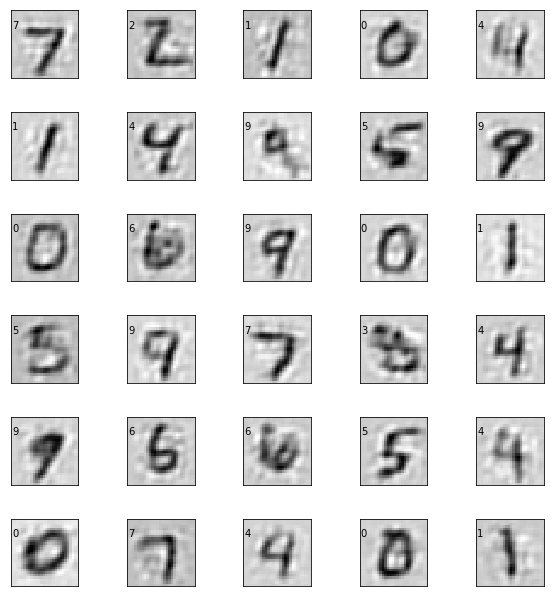

In [54]:
#Test Processing:
output = []
with tf.Session() as sess:
    if os.path.exists('tmp/checkpoint'):        
        saver.restore(sess, 'tmp/model.ckpt')
        total_batch  = int(len(test_images)/batch_size)
        msg = "Test batch={:d}, lose={:.4f}"
        for b in tqdm(range(total_batch)):
            batch = test_images[b*batch_size:(b+1)*batch_size]
            imgs = batch.reshape((-1,28,28,1))
            cost,out = sess.run([loss,conv_final], feed_dict={input_x:batch})
            output.append(out)
            print(msg.format(b,cost))

    else :
        print("Please run training part first")
    fig1 = plt.figure(figsize=(8,8))
    fig1.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.5, wspace=0.05)
    for i in range(30):
        image = np.reshape(test_images[i],[28,28])
        ax=fig1.add_subplot(6,5,i+1,xticks=[],yticks=[]) 
        ax.imshow(image,cmap=plt.cm.binary,interpolation='nearest') 
        ax.text(0,7,str(test_labels[i]))
    plt.show()
    print("---------------------------------------------------")
    fig = plt.figure(figsize=(8,8))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.5, wspace=0.05)
    for i in range(30):
        image = np.reshape(output[0][i],[28,28])
        ax=fig.add_subplot(6,5,i+1,xticks=[],yticks=[]) 
        ax.imshow(image,cmap=plt.cm.binary,interpolation='nearest') 
        ax.text(0,7,str(test_labels[i]))
    plt.show()